# 1019 temp visualization 

#### import

In [1]:
import seaborn as sn
import matplotlib.pyplot as plt
from qiskit.visualization import plot_histogram
from datetime import datetime
import numpy as np
from itertools import permutations

from qiskit_finance.data_providers import YahooDataProvider
import json # Necessary for YahooDataProvider
import http.client # Necessary for YahooDataProvider

import pandas as pd
#import pandas_datareader as web

import os

from docplex.mp.model import Model

from qiskit_optimization.translators import from_docplex_mp
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit.algorithms import NumPyMinimumEigensolver
from qiskit_optimization.converters import LinearEqualityToPenalty

from qiskit.circuit.library import TwoLocal # For Ansatz

from qiskit.algorithms.optimizers import COBYLA, ADAM, NELDER_MEAD, POWELL, SPSA, QNSPSA
from qiskit.opflow import CVaRExpectation
from qiskit.opflow import PauliExpectation

from qiskit.algorithms import VQE
from qiskit.algorithms import QAOA

from qiskit import Aer

In [2]:
from dimod import ConstrainedQuadraticModel, Integer
from dwave.system import LeapHybridCQMSampler
import easydict
# import kqc_custom
from sklearn.linear_model import LinearRegression
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
args = easydict.EasyDict()
#my_api_token = TOKEN
my_api_token = "DEV-8be99a69b1c9b92319d76a12d5c8b4fde79963b4"
args['token'] = "DEV-8be99a69b1c9b92319d76a12d5c8b4fde79963b4"
sampler = LeapHybridCQMSampler(token = args['token'])

#### D-wave model

In [4]:
# 변수선택에서 가져온 dwave function

def dwave(x,y):
    data_x = pd.DataFrame(x)
    data_y = pd.DataFrame(y)
    p = data_x.shape[1]
    Q = np.abs(data_x.corr())
    beta = -Q.apply(sum)
    for i in range(p) : 
        Q.iloc[i,i] = 0 
        r_squared_list = []
        names = []
        for i in range( len(data_x.columns )) :
            names.append("x"+str(i))
        data_x.columns = names    
            
    beta2 = -Q.apply(sum)
    beta2_with_r2 = beta2 - partial_r1(x,y)
    B=beta2_with_r2
    integer_list = []
    for i in range(10):
        integer_list.append(Integer(str("x")+str("0")+str("0")+str(i), upper_bound=1,lower_bound=0))
    for i in range(10,100) :
        integer_list.append(Integer(str("x")+str("0")+str(i), upper_bound=1,lower_bound=0))
    for i in range(100,p) :
        integer_list.append(Integer(str("x")+str(i), upper_bound=1,lower_bound=0))
        
    linear_qubo = B[0]*integer_list[0]*0
    for i in range(p): 
        linear_qubo = linear_qubo + B[i]*integer_list[i]
    
    quadratic_qubo = Q[0][0]*integer_list[0]*integer_list[0]*0
    for j in range(p):
        for i in range(p):
            quadratic_qubo= quadratic_qubo+Q[i][j]*integer_list[i]*integer_list[j]
    
    Qubo = linear_qubo + quadratic_qubo
    cqm= ConstrainedQuadraticModel()
    cqm.set_objective(Qubo)
    sampleset = sampler.sample_cqm(cqm)
    
    result = sampleset.first[0]
    result_list=list(zip(result.keys(), result.values()))
    
    data_x_result=pd.DataFrame(result_list).T.loc[[1]]
    names = []
    for i in range( len(data_x_result.columns )) :
        names.append("x"+str(i))
    data_x_result.columns = names  
    data_y.columns = ["y"]
    
    data_x_result.index = ["Selection"]
    data_x_result=pd.to_numeric(data_x_result.T["Selection"])
    
    concat_x = pd.concat([pd.DataFrame(data_x_result).T, data_x], axis = 0)
    concat_x_one=concat_x.T[concat_x.T["Selection"]==1].T
    data_x_one =concat_x_one.loc[0:,:]
    
    
    mse_result=mse( np.array(data_x_one) ,np.array(data_y))
    aic_result = (len(data_x_one)* np.log(mse_result) - 10 *np.log(len(data_x_one)) + 2* len(data_x_one.columns))
    cn_result = cn(data_x_one)
    return result, mse_result, aic_result, cn_result

#### Data loader

In [46]:
# data = pd.read_excel(('./부동산 데이터.xlsx'),index_col=0)
data = pd.read_csv("./seoul_5year_250steps_25gu.csv", encoding="UTF-8", header= "infer")

In [6]:
beta= {'종로구': 0.7043230350406724,
 '중구': 0.7013707352553286,
 '용산구': 0.6227240385741704,
 '성동구': 0.6774652574577301,
 '광진구': 0.7774304796156825,
 '동대문구': 0.7312901961288749,
 '중랑구': 0.8495435178569114,
 '성북구': 0.7353748267964536,
 '강북구': 0.5590302816841793,
 '도봉구': 0.6104941055445325,
 '노원구': 0.5814943813430039,
 '은평구': 0.6848609382154561,
 '서대문구': 0.8959956736444682,
 '마포구': 0.7980492464899224,
 '양천구': 0.6786819907017784,
 '강서구': 0.7174780572351959,
 '구로구': 0.677190182997848,
 '금천구': 0.7106326446994807,
 '영등포구': 0.7866140518456497,
 '동작구': 0.7137865551481725,
 '관악구': 0.8001399119261533,
 '서초구': 0.7802900931734599,
 '강남구': 0.6746651464105473,
 '송파구': 0.705094842287758,
 '강동구': 0.7919404607562062}

Q = pd.DataFrame([[1.00682001e-05, 8.25395637e-06, 4.39375836e-06, 6.84137795e-06,
        6.46402755e-06, 6.64405292e-06, 5.02962050e-06, 8.43589135e-06,
        8.19468754e-06, 8.88946246e-06, 1.00874159e-05, 1.10857348e-05,
        1.34619620e-05, 8.49167276e-06, 5.95900832e-06, 7.48430311e-06,
        6.93096540e-06, 1.03322631e-05, 9.73130024e-06, 6.49924418e-06,
        6.23553238e-06, 8.45107912e-06, 7.50212758e-06, 7.07619043e-06,
        5.17701993e-06, 7.25435545e-06, 6.91303747e-06, 1.19529178e-05],
       [8.25395637e-06, 1.31586466e-05, 6.51602479e-06, 9.61132426e-06,
        1.00166363e-05, 1.20684154e-05, 9.65049109e-06, 1.31789070e-05,
        1.08553903e-05, 1.42602462e-05, 1.62950868e-05, 1.61407087e-05,
        1.85124607e-05, 1.13814904e-05, 9.66127679e-06, 1.17848706e-05,
        1.43198471e-05, 1.41318133e-05, 1.50251914e-05, 1.04266390e-05,
        1.23613655e-05, 1.36480015e-05, 1.16293550e-05, 1.16364711e-05,
        1.07072094e-05, 1.30852945e-05, 1.09529555e-05, 1.12958304e-05],
       [4.39375836e-06, 6.51602479e-06, 6.75335317e-06, 4.95338394e-06,
        5.79512733e-06, 6.15382130e-06, 4.78051493e-06, 5.91733358e-06,
        6.13536996e-06, 6.96774825e-06, 7.99138828e-06, 7.88267258e-06,
        8.66507488e-06, 6.65147763e-06, 4.69599671e-06, 5.27837742e-06,
        6.50486767e-06, 7.34871259e-06, 7.46058308e-06, 4.89122893e-06,
        6.18369237e-06, 6.17874513e-06, 5.98362107e-06, 6.42451844e-06,
        5.44738058e-06, 6.13049084e-06, 5.85442160e-06, 5.47921733e-06],
       [6.84137795e-06, 9.61132426e-06, 4.95338394e-06, 1.04024969e-05,
        7.63734651e-06, 8.28981835e-06, 6.82100598e-06, 9.76505921e-06,
        7.94749803e-06, 1.04736745e-05, 1.17206838e-05, 1.15634381e-05,
        1.37990877e-05, 9.27769809e-06, 7.16492449e-06, 8.92460873e-06,
        1.00095975e-05, 1.04793145e-05, 1.10781895e-05, 7.09151212e-06,
        9.09957654e-06, 1.07583568e-05, 9.13688841e-06, 7.86801338e-06,
        7.36828056e-06, 8.81319175e-06, 8.29555263e-06, 8.85957365e-06],
       [6.46402755e-06, 1.00166363e-05, 5.79512733e-06, 7.63734651e-06,
        1.38765476e-05, 9.43751779e-06, 7.42838869e-06, 1.05269054e-05,
        8.11552790e-06, 1.01591879e-05, 1.04482265e-05, 1.07740458e-05,
        1.11886641e-05, 8.79593560e-06, 7.31633427e-06, 9.23110341e-06,
        1.04736141e-05, 1.16733598e-05, 1.05930695e-05, 6.41834774e-06,
        9.86690803e-06, 1.08628494e-05, 9.21827091e-06, 1.03131618e-05,
        9.62164108e-06, 9.60299599e-06, 9.65811368e-06, 8.76290662e-06],
       [6.64405292e-06, 1.20684154e-05, 6.15382130e-06, 8.28981835e-06,
        9.43751779e-06, 1.60507826e-05, 1.02879246e-05, 1.20934600e-05,
        9.43391209e-06, 1.22905669e-05, 1.33334053e-05, 1.37527606e-05,
        1.57888320e-05, 1.01392405e-05, 8.55181217e-06, 1.04829643e-05,
        1.26560729e-05, 1.18289022e-05, 1.24165787e-05, 8.64940674e-06,
        1.05987688e-05, 1.22163341e-05, 9.20841519e-06, 1.08957657e-05,
        1.10026541e-05, 1.37322537e-05, 1.10871929e-05, 9.35414490e-06],
       [5.02962050e-06, 9.65049109e-06, 4.78051493e-06, 6.82100598e-06,
        7.42838869e-06, 1.02879246e-05, 1.06665461e-05, 9.13999579e-06,
        7.29567605e-06, 1.02415634e-05, 1.12589287e-05, 1.00670804e-05,
        1.22622821e-05, 7.50128720e-06, 6.98042065e-06, 8.22107528e-06,
        1.12833881e-05, 9.80959641e-06, 9.71501858e-06, 8.34050288e-06,
        8.88614516e-06, 8.59284436e-06, 7.67356555e-06, 8.65129990e-06,
        9.49512911e-06, 1.16254348e-05, 8.36021585e-06, 7.20942034e-06],
       [8.43589135e-06, 1.31789070e-05, 5.91733358e-06, 9.76505921e-06,
        1.05269054e-05, 1.20934600e-05, 9.13999579e-06, 1.59496560e-05,
        1.10098791e-05, 1.39890344e-05, 1.63400608e-05, 1.63113214e-05,
        1.87921937e-05, 1.13604959e-05, 9.91236525e-06, 1.23515822e-05,
        1.38949568e-05, 1.41706779e-05, 1.48509144e-05, 1.01183766e-05,
        1.22242606e-05, 1.46032465e-05, 1.19800196e-05, 1.15415956e-05,
        9.62964157e-06, 1.21916195e-05, 1.14305976e-05, 1.18044021e-05],
       [8.19468754e-06, 1.08553903e-05, 6.13536996e-06, 7.94749803e-06,
        8.11552790e-06, 9.43391209e-06, 7.29567605e-06, 1.10098791e-05,
        1.18081155e-05, 1.17600095e-05, 1.41767718e-05, 1.49472821e-05,
        1.62072335e-05, 1.03560642e-05, 7.91826940e-06, 8.85960132e-06,
        1.02908934e-05, 1.23212631e-05, 1.31104692e-05, 8.43054436e-06,
        9.53496050e-06, 1.06010036e-05, 9.25520596e-06, 9.40819055e-06,
        7.79011160e-06, 9.98169502e-06, 8.97364898e-06, 1.06957825e-05],
       [8.88946246e-06, 1.42602462e-05, 6.96774825e-06, 1.04736745e-05,
        1.01591879e-05, 1.22905669e-05, 1.02415634e-05, 1.39890344e-05,
        1.17600095e-05, 1.78694526e-05, 1.81737909e-05, 1.80039222e-05,
        2.11701155e-05, 1.32885085e-05, 1.09284141e-05, 1.28514024e-05,
        1.49182060e-05, 1.55379853e-05, 1.68462413e-05, 1.15188017e-05,
        1.35489647e-05, 1.48612244e-05, 1.30926596e-05, 1.17052353e-05,
        1.01668804e-05, 1.33413705e-05, 1.10175291e-05, 1.23109896e-05],
       [1.00874159e-05, 1.62950868e-05, 7.99138828e-06, 1.17206838e-05,
        1.04482265e-05, 1.33334053e-05, 1.12589287e-05, 1.63400608e-05,
        1.41767718e-05, 1.81737909e-05, 2.65898272e-05, 2.25746599e-05,
        2.57328081e-05, 1.40858113e-05, 1.21659592e-05, 1.36141943e-05,
        1.79493498e-05, 1.87655390e-05, 2.00098460e-05, 1.43132724e-05,
        1.47854389e-05, 1.62300646e-05, 1.43680696e-05, 1.33085768e-05,
        1.07577363e-05, 1.40081749e-05, 1.16254085e-05, 1.38845191e-05],
       [1.10857348e-05, 1.61407087e-05, 7.88267258e-06, 1.15634381e-05,
        1.07740458e-05, 1.37527606e-05, 1.00670804e-05, 1.63113214e-05,
        1.49472821e-05, 1.80039222e-05, 2.25746599e-05, 2.50863650e-05,
        2.53626632e-05, 1.46139925e-05, 1.21613789e-05, 1.40962376e-05,
        1.66072888e-05, 1.74068270e-05, 1.92299285e-05, 1.29048882e-05,
        1.45882974e-05, 1.65158119e-05, 1.41641995e-05, 1.30497217e-05,
        1.02402354e-05, 1.40011204e-05, 1.27316733e-05, 1.50927845e-05],
       [1.34619620e-05, 1.85124607e-05, 8.66507488e-06, 1.37990877e-05,
        1.11886641e-05, 1.57888320e-05, 1.22622821e-05, 1.87921937e-05,
        1.62072335e-05, 2.11701155e-05, 2.57328081e-05, 2.53626632e-05,
        3.10831153e-05, 1.70307626e-05, 1.33934817e-05, 1.62954743e-05,
        1.85778500e-05, 2.05479941e-05, 2.23972905e-05, 1.54152393e-05,
        1.63206059e-05, 1.91926407e-05, 1.62528490e-05, 1.49307499e-05,
        1.13885592e-05, 1.62306855e-05, 1.35779509e-05, 1.79414685e-05],
       [8.49167276e-06, 1.13814904e-05, 6.65147763e-06, 9.27769809e-06,
        8.79593560e-06, 1.01392405e-05, 7.50128720e-06, 1.13604959e-05,
        1.03560642e-05, 1.32885085e-05, 1.40858113e-05, 1.46139925e-05,
        1.70307626e-05, 1.44320489e-05, 9.11394035e-06, 9.74844783e-06,
        1.06877620e-05, 1.31646064e-05, 1.37959378e-05, 9.17221684e-06,
        1.05593305e-05, 1.14042244e-05, 1.12293565e-05, 9.58643097e-06,
        7.31672271e-06, 9.59924050e-06, 9.01472501e-06, 1.07971983e-05],
       [5.95900832e-06, 9.66127679e-06, 4.69599671e-06, 7.16492449e-06,
        7.31633427e-06, 8.55181217e-06, 6.98042065e-06, 9.91236525e-06,
        7.91826940e-06, 1.09284141e-05, 1.21659592e-05, 1.21613789e-05,
        1.33934817e-05, 9.11394035e-06, 9.16773514e-06, 8.62080363e-06,
        1.03121082e-05, 1.05510643e-05, 1.12438863e-05, 8.05369136e-06,
        9.57505819e-06, 1.00132753e-05, 9.36382537e-06, 8.11163707e-06,
        7.09694915e-06, 8.81513316e-06, 8.08131412e-06, 8.39410920e-06],
       [7.48430311e-06, 1.17848706e-05, 5.27837742e-06, 8.92460873e-06,
        9.23110341e-06, 1.04829643e-05, 8.22107528e-06, 1.23515822e-05,
        8.85960132e-06, 1.28514024e-05, 1.36141943e-05, 1.40962376e-05,
        1.62954743e-05, 9.74844783e-06, 8.62080363e-06, 1.31449396e-05,
        1.33791132e-05, 1.19118834e-05, 1.30955349e-05, 8.86632492e-06,
        1.11897467e-05, 1.33966135e-05, 1.07192340e-05, 9.95845370e-06,
        9.66098862e-06, 1.13605362e-05, 1.03325136e-05, 1.04220691e-05],
       [6.93096540e-06, 1.43198471e-05, 6.50486767e-06, 1.00095975e-05,
        1.04736141e-05, 1.26560729e-05, 1.12833881e-05, 1.38949568e-05,
        1.02908934e-05, 1.49182060e-05, 1.79493498e-05, 1.66072888e-05,
        1.85778500e-05, 1.06877620e-05, 1.03121082e-05, 1.33791132e-05,
        2.00206571e-05, 1.48498498e-05, 1.63120666e-05, 1.28736008e-05,
        1.42365281e-05, 1.49554834e-05, 1.29026870e-05, 1.27364961e-05,
        1.26132940e-05, 1.45889120e-05, 1.13702278e-05, 1.04356398e-05],
       [1.03322631e-05, 1.41318133e-05, 7.34871259e-06, 1.04793145e-05,
        1.16733598e-05, 1.18289022e-05, 9.80959641e-06, 1.41706779e-05,
        1.23212631e-05, 1.55379853e-05, 1.87655390e-05, 1.74068270e-05,
        2.05479941e-05, 1.31646064e-05, 1.05510643e-05, 1.19118834e-05,
        1.48498498e-05, 1.85914102e-05, 1.69367434e-05, 1.20202312e-05,
        1.28718244e-05, 1.41533768e-05, 1.32244209e-05, 1.25828532e-05,
        1.00661234e-05, 1.24926221e-05, 1.05056985e-05, 1.36665463e-05],
       [9.73130024e-06, 1.50251914e-05, 7.46058308e-06, 1.10781895e-05,
        1.05930695e-05, 1.24165787e-05, 9.71501858e-06, 1.48509144e-05,
        1.31104692e-05, 1.68462413e-05, 2.00098460e-05, 1.92299285e-05,
        2.23972905e-05, 1.37959378e-05, 1.12438863e-05, 1.30955349e-05,
        1.63120666e-05, 1.69367434e-05, 2.05808678e-05, 1.31867754e-05,
        1.40798068e-05, 1.65699976e-05, 1.42455742e-05, 1.29098899e-05,
        9.89810285e-06, 1.26680855e-05, 1.16292019e-05, 1.33128516e-05],
       [6.49924418e-06, 1.04266390e-05, 4.89122893e-06, 7.09151212e-06,
        6.41834774e-06, 8.64940674e-06, 8.34050288e-06, 1.01183766e-05,
        8.43054436e-06, 1.15188017e-05, 1.43132724e-05, 1.29048882e-05,
        1.54152393e-05, 9.17221684e-06, 8.05369136e-06, 8.86632492e-06,
        1.28736008e-05, 1.20202312e-05, 1.31867754e-05, 1.29191853e-05,
        9.68988328e-06, 1.01841809e-05, 9.67352744e-06, 8.83414347e-06,
        6.92214569e-06, 9.52586224e-06, 7.39631094e-06, 9.06300943e-06],
       [6.23553238e-06, 1.23613655e-05, 6.18369237e-06, 9.09957654e-06,
        9.86690803e-06, 1.05987688e-05, 8.88614516e-06, 1.22242606e-05,
        9.53496050e-06, 1.35489647e-05, 1.47854389e-05, 1.45882974e-05,
        1.63206059e-05, 1.05593305e-05, 9.57505819e-06, 1.11897467e-05,
        1.42365281e-05, 1.28718244e-05, 1.40798068e-05, 9.68988328e-06,
        1.39286017e-05, 1.29858534e-05, 1.17577589e-05, 1.06429994e-05,
        1.07481014e-05, 1.22787669e-05, 1.01207382e-05, 9.04602729e-06],
       [8.45107912e-06, 1.36480015e-05, 6.17874513e-06, 1.07583568e-05,
        1.08628494e-05, 1.22163341e-05, 8.59284436e-06, 1.46032465e-05,
        1.06010036e-05, 1.48612244e-05, 1.62300646e-05, 1.65158119e-05,
        1.91926407e-05, 1.14042244e-05, 1.00132753e-05, 1.33966135e-05,
        1.49554834e-05, 1.41533768e-05, 1.65699976e-05, 1.01841809e-05,
        1.29858534e-05, 1.81886467e-05, 1.26904937e-05, 1.19667122e-05,
        1.01495501e-05, 1.17991367e-05, 1.20770173e-05, 1.19037483e-05],
       [7.50212758e-06, 1.16293550e-05, 5.98362107e-06, 9.13688841e-06,
        9.21827091e-06, 9.20841519e-06, 7.67356555e-06, 1.19800196e-05,
        9.25520596e-06, 1.30926596e-05, 1.43680696e-05, 1.41641995e-05,
        1.62528490e-05, 1.12293565e-05, 9.36382537e-06, 1.07192340e-05,
        1.29026870e-05, 1.32244209e-05, 1.42455742e-05, 9.67352744e-06,
        1.17577589e-05, 1.26904937e-05, 1.30185322e-05, 9.92287294e-06,
        8.03160422e-06, 1.03263118e-05, 9.21969897e-06, 1.02706820e-05],
       [7.07619043e-06, 1.16364711e-05, 6.42451844e-06, 7.86801338e-06,
        1.03131618e-05, 1.08957657e-05, 8.65129990e-06, 1.15415956e-05,
        9.40819055e-06, 1.17052353e-05, 1.33085768e-05, 1.30497217e-05,
        1.49307499e-05, 9.58643097e-06, 8.11163707e-06, 9.95845370e-06,
        1.27364961e-05, 1.25828532e-05, 1.29098899e-05, 8.83414347e-06,
        1.06429994e-05, 1.19667122e-05, 9.92287294e-06, 1.38106967e-05,
        1.03773268e-05, 1.19286372e-05, 1.03369404e-05, 9.39770598e-06],
       [5.17701993e-06, 1.07072094e-05, 5.44738058e-06, 7.36828056e-06,
        9.62164108e-06, 1.10026541e-05, 9.49512911e-06, 9.62964157e-06,
        7.79011160e-06, 1.01668804e-05, 1.07577363e-05, 1.02402354e-05,
        1.13885592e-05, 7.31672271e-06, 7.09694915e-06, 9.66098862e-06,
        1.26132940e-05, 1.00661234e-05, 9.89810285e-06, 6.92214569e-06,
        1.07481014e-05, 1.01495501e-05, 8.03160422e-06, 1.03773268e-05,
        1.46278871e-05, 1.41629797e-05, 1.02409690e-05, 7.15985655e-06],
       [7.25435545e-06, 1.30852945e-05, 6.13049084e-06, 8.81319175e-06,
        9.60299599e-06, 1.37322537e-05, 1.16254348e-05, 1.21916195e-05,
        9.98169502e-06, 1.33413705e-05, 1.40081749e-05, 1.40011204e-05,
        1.62306855e-05, 9.59924050e-06, 8.81513316e-06, 1.13605362e-05,
        1.45889120e-05, 1.24926221e-05, 1.26680855e-05, 9.52586224e-06,
        1.22787669e-05, 1.17991367e-05, 1.03263118e-05, 1.19286372e-05,
        1.41629797e-05, 1.79661884e-05, 1.15669916e-05, 1.00523780e-05],
       [6.91303747e-06, 1.09529555e-05, 5.85442160e-06, 8.29555263e-06,
        9.65811368e-06, 1.10871929e-05, 8.36021585e-06, 1.14305976e-05,
        8.97364898e-06, 1.10175291e-05, 1.16254085e-05, 1.27316733e-05,
        1.35779509e-05, 9.01472501e-06, 8.08131412e-06, 1.03325136e-05,
        1.13702278e-05, 1.05056985e-05, 1.16292019e-05, 7.39631094e-06,
        1.01207382e-05, 1.20770173e-05, 9.21969897e-06, 1.03369404e-05,
        1.02409690e-05, 1.15669916e-05, 1.23500709e-05, 9.34838949e-06],
       [1.19529178e-05, 1.12958304e-05, 5.47921733e-06, 8.85957365e-06,
        8.76290662e-06, 9.35414490e-06, 7.20942034e-06, 1.18044021e-05,
        1.06957825e-05, 1.23109896e-05, 1.38845191e-05, 1.50927845e-05,
        1.79414685e-05, 1.07971983e-05, 8.39410920e-06, 1.04220691e-05,
        1.04356398e-05, 1.36665463e-05, 1.33128516e-05, 9.06300943e-06,
        9.04602729e-06, 1.19037483e-05, 1.02706820e-05, 9.39770598e-06,
        7.15985655e-06, 1.00523780e-05, 9.34838949e-06, 1.49254522e-05]])

In [7]:
names = ["종로구","중구","용산구","성동구","광진구","동대문구","중랑구","성북구","강북구","도봉구",
         "노원구","은평구","서대문구","마포구","양천구","강서구","구로구","금천구","영등포구",
         "동작구","관악구","서초구","강남구","송파구","강동구"]

### Main

#### Setting the parameter

In [8]:
#integer_list = []
#for i in range(10):
#integer_list.append(Integer(str("x")+str("0")+str("0")+str(i), upper_bound=1,lower_bound=0))
#for i in range(10,25) :
#integer_list.append(Integer(str("x")+str("0")+str(i), upper_bound=1,lower_bound=0))
beta_list = list ( beta.values() )
B=beta_list

integer_list = []
for i in range(25):
    integer_list.append(Integer(str(names[i]), upper_bound=1,lower_bound=0))

linear_qubo = B[0]*integer_list[0]*0
for i in range(25): 
    linear_qubo = linear_qubo + B[i]*integer_list[i]

for i in range(25) : 
    Q.iloc[i,i] = 0
quadratic_qubo = Q[0][0]*integer_list[0]*integer_list[0]*0
for j in range(25):
    for i in range(25):
        quadratic_qubo= quadratic_qubo+Q[i][j]*integer_list[i]*integer_list[j]

In [9]:
# Qubo 와 result
Qubo = -linear_qubo + quadratic_qubo
cqm= ConstrainedQuadraticModel()
cqm.set_objective(Qubo)
sampleset = sampler.sample_cqm(cqm)

result = sampleset.first[0]
result_list=list(zip(result.keys(), result.values()))

In [10]:
Qubo

QuadraticModel({'종로구': -0.7043230350406724, '중구': -0.7013707352553286, '용산구': -0.6227240385741704, '성동구': -0.6774652574577301, '광진구': -0.7774304796156825, '동대문구': -0.7312901961288749, '중랑구': -0.8495435178569114, '성북구': -0.7353748267964536, '강북구': -0.5590302816841793, '도봉구': -0.6104941055445325, '노원구': -0.5814943813430039, '은평구': -0.6848609382154561, '서대문구': -0.8959956736444682, '마포구': -0.7980492464899224, '양천구': -0.6786819907017784, '강서구': -0.7174780572351959, '구로구': -0.677190182997848, '금천구': -0.7106326446994807, '영등포구': -0.7866140518456497, '동작구': -0.7137865551481725, '관악구': -0.8001399119261533, '서초구': -0.7802900931734599, '강남구': -0.6746651464105473, '송파구': -0.705094842287758, '강동구': -0.7919404607562062}, {('종로구', '종로구'): 0.0, ('중구', '종로구'): 1.650791274e-05, ('중구', '중구'): 0.0, ('용산구', '종로구'): 8.78751672e-06, ('용산구', '중구'): 1.303204958e-05, ('용산구', '용산구'): 0.0, ('성동구', '종로구'): 1.36827559e-05, ('성동구', '중구'): 1.922264852e-05, ('성동구', '용산구'): 9.90676788e-06, ('성동구', '성동구'): 0.0, ('광진구', 

In [11]:
# 예상한대로, Q 값이 작아서 모든 부동산을 선택하는 결과가 나타남.
result

{'강남구': 1.0,
 '강동구': 1.0,
 '강북구': 1.0,
 '강서구': 1.0,
 '관악구': 1.0,
 '광진구': 1.0,
 '구로구': 1.0,
 '금천구': 1.0,
 '노원구': 1.0,
 '도봉구': 1.0,
 '동대문구': 1.0,
 '동작구': 1.0,
 '마포구': 1.0,
 '서대문구': 1.0,
 '서초구': 1.0,
 '성동구': 1.0,
 '성북구': 1.0,
 '송파구': 1.0,
 '양천구': 1.0,
 '영등포구': 1.0,
 '용산구': 1.0,
 '은평구': 1.0,
 '종로구': 1.0,
 '중구': 1.0,
 '중랑구': 1.0}

In [12]:
data.corr()

/var/folders/9y/x8rs72cn71v99tfw7qhh607c0000gn/T/ipykernel_6419/2627137660.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  data.corr()


,전국,서울,종로구,중구,용산구,성동구,광진구,동대문구,중랑구,성북구,...,구로구,금천구,영등포구,동작구,관악구,서초구,강남구,송파구,강동구,수도권
전국,1.000000,0.969191,0.962341,0.970625,0.963629,0.958985,0.948711,0.966024,0.982398,0.962979,...,0.969876,0.958762,0.942854,0.960215,0.957566,0.973536,0.952761,0.962095,0.966786,0.997220
서울,0.969191,1.000000,0.997063,0.998873,0.993204,0.997531,0.995173,0.998865,0.997481,0.998636,...,0.999226,0.996502,0.995575,0.998212,0.998438,0.993933,0.994788,0.997956,0.997198,0.984112
종로구,0.962341,0.997063,1.000000,0.993937,0.997217,0.996249,0.993787,0.995889,0.994151,0.993569,...,0.995638,0.993975,0.994743,0.995025,0.996239,0.996690,0.995341,0.995304,0.995931,0.978023
중구,0.970625,0.998873,0.993937,1.000000,0.988754,0.995836,0.992789,0.997823,0.996435,0.998698,...,0.998605,0.994792,0.993413,0.997695,0.997129,0.989810,0.991702,0.995988,0.995431,0.984462
용산구,0.963629,0.993204,0.997217,0.988754,1.000000,0.993538,0.987735,0.993271,0.991147,0.986922,...,0.990342,0.987451,0.989186,0.992062,0.991774,0.998169,0.993363,0.991332,0.995938,0.978367
성동구,0.958985,0.997531,0.996249,0.995836,0.993538,1.000000,0.993857,0.997792,0.992753,0.995699,...,0.994546,0.991350,0.994985,0.997363,0.996232,0.992038,0.996133,0.997266,0.998101,0.975837
광진구,0.948711,0.995173,0.993787,0.992789,0.987735,0.993857,1.000000,0.991665,0.988142,0.994619,...,0.994081,0.997697,0.997482,0.992623,0.995349,0.986852,0.996448,0.997638,0.990051,0.967865
동대문구,0.966024,0.998865,0.995889,0.997823,0.993271,0.997792,0.991665,1.000000,0.995916,0.997590,...,0.997626,0.992967,0.994607,0.999211,0.998291,0.992736,0.992327,0.995402,0.998107,0.981834
중랑구,0.982398,0.997481,0.994151,0.996435,0.991147,0.992753,0.988142,0.995916,1.000000,0.994698,...,0.997348,0.992226,0.987314,0.993322,0.993193,0.994732,0.988489,0.993694,0.994289,0.992963
성북구,0.962979,0.998636,0.993569,0.998698,0.986922,0.995699,0.994619,0.997590,0.994698,1.000000,...,0.998713,0.996045,0.995602,0.997414,0.998318,0.987386,0.991684,0.996278,0.993792,0.979128


In [13]:
# 원 데이터의 공분산, 상관계수 (상관계수는 거의 다 높게 나옴)

data = pd.DataFrame(data)
np.log(data.corr())

/var/folders/9y/x8rs72cn71v99tfw7qhh607c0000gn/T/ipykernel_6419/3447938243.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  np.log(data.corr())


,전국,서울,종로구,중구,용산구,성동구,광진구,동대문구,중랑구,성북구,...,구로구,금천구,영등포구,동작구,관악구,서초구,강남구,송파구,강동구,수도권
전국,0.000000,-0.031293,-0.038387,-0.029815,-0.037049,-0.041880,-0.052651,-0.034566,-0.017758,-0.037724,...,-0.030587,-0.042113,-0.058844,-0.040598,-0.043361,-0.026820,-0.048391,-0.038642,-0.033778,-0.002783
서울,-0.031293,0.000000,-0.002941,-0.001128,-0.006819,-0.002472,-0.004839,-0.001135,-0.002522,-0.001365,...,-0.000774,-0.003504,-0.004435,-0.001789,-0.001563,-0.006086,-0.005225,-0.002046,-0.002806,-0.016015
종로구,-0.038387,-0.002941,0.000000,-0.006081,-0.002787,-0.003758,-0.006232,-0.004119,-0.005866,-0.006451,...,-0.004371,-0.006043,-0.005271,-0.004988,-0.003768,-0.003315,-0.004670,-0.004707,-0.004078,-0.022222
중구,-0.029815,-0.001128,-0.006081,0.000000,-0.011309,-0.004173,-0.007237,-0.002180,-0.003571,-0.001303,...,-0.001396,-0.005222,-0.006609,-0.002308,-0.002875,-0.010242,-0.008332,-0.004020,-0.004580,-0.015660
용산구,-0.037049,-0.006819,-0.002787,-0.011309,0.000000,-0.006483,-0.012341,-0.006752,-0.008893,-0.013164,...,-0.009705,-0.012628,-0.010873,-0.007970,-0.008260,-0.001833,-0.006659,-0.008706,-0.004070,-0.021871
성동구,-0.041880,-0.002472,-0.003758,-0.004173,-0.006483,0.000000,-0.006162,-0.002211,-0.007273,-0.004310,...,-0.005469,-0.008687,-0.005028,-0.002641,-0.003775,-0.007994,-0.003875,-0.002737,-0.001901,-0.024460
광진구,-0.052651,-0.004839,-0.006232,-0.007237,-0.012341,-0.006162,0.000000,-0.008370,-0.011929,-0.005396,...,-0.005937,-0.002305,-0.002521,-0.007404,-0.004662,-0.013235,-0.003559,-0.002364,-0.009999,-0.032662
동대문구,-0.034566,-0.001135,-0.004119,-0.002180,-0.006752,-0.002211,-0.008370,0.000000,-0.004092,-0.002412,...,-0.002377,-0.007058,-0.005407,-0.000790,-0.001710,-0.007291,-0.007703,-0.004608,-0.001895,-0.018333
중랑구,-0.017758,-0.002522,-0.005866,-0.003571,-0.008893,-0.007273,-0.011929,-0.004092,0.000000,-0.005316,...,-0.002656,-0.007804,-0.012767,-0.006701,-0.006831,-0.005281,-0.011577,-0.006326,-0.005727,-0.007061
성북구,-0.037724,-0.001365,-0.006451,-0.001303,-0.013164,-0.004310,-0.005396,-0.002412,-0.005316,0.000000,...,-0.001288,-0.003963,-0.004408,-0.002589,-0.001683,-0.012694,-0.008351,-0.003729,-0.006228,-0.021093


In [14]:
data.cov()

/var/folders/9y/x8rs72cn71v99tfw7qhh607c0000gn/T/ipykernel_6419/4020818503.py:1: FutureWarning: The default value of numeric_only in DataFrame.cov is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  data.cov()


,전국,서울,종로구,중구,용산구,성동구,광진구,동대문구,중랑구,성북구,...,구로구,금천구,영등포구,동작구,관악구,서초구,강남구,송파구,강동구,수도권
전국,100.869906,118.134431,77.623148,98.035256,105.952062,102.878170,106.496295,109.166014,109.437571,118.860861,...,132.901619,113.763887,123.689081,122.785049,108.546323,99.277770,102.004683,115.875339,99.846203,126.247861
서울,118.134431,147.289759,97.183022,121.912006,131.960411,129.313377,134.990919,136.399195,134.273036,148.948084,...,165.456329,142.881909,157.821534,154.242949,136.764457,122.479218,128.698190,145.241176,124.448007,150.550744
종로구,77.623148,97.183022,64.500504,80.276849,87.677915,85.463424,89.206173,89.993483,88.558838,98.066583,...,109.097917,94.312646,104.351471,101.744635,90.304821,81.275730,85.213626,95.858203,82.249062,99.010862
중구,98.035256,121.912006,80.276849,101.134612,108.857239,106.971606,111.590347,112.907245,111.146778,123.431256,...,137.017811,118.193914,130.492566,127.744923,113.179280,101.069698,106.313071,120.114711,102.939301,124.796079
용산구,105.952062,131.960411,87.677915,108.857239,119.849961,116.180766,120.859082,122.350340,120.352426,132.783202,...,147.923507,127.716633,141.450007,138.278186,122.545494,110.953744,115.926445,130.145750,112.117067,135.012067
성동구,102.878170,129.313377,85.463424,106.971606,116.180766,114.093646,118.651871,119.919334,117.617008,130.707354,...,144.940203,125.103882,138.820377,135.637566,120.103816,107.591566,113.423612,127.742093,109.628975,131.389310
광진구,106.496295,134.990919,89.206173,111.590347,120.859082,118.651871,124.922236,124.710596,122.500345,136.621124,...,151.591497,131.744216,145.623278,141.253841,125.562772,111.993059,118.721635,133.716545,113.788329,136.359967
동대문구,109.166014,136.399195,89.993483,112.907245,122.350340,119.919334,124.710596,126.600973,124.290925,137.946936,...,153.150825,131.997591,146.176048,143.143513,126.777302,113.415171,119.022390,134.310301,115.482387,139.254308
중랑구,109.437571,134.273036,88.558838,111.146778,120.352426,117.617008,122.500345,124.290925,123.025762,135.590946,...,150.930836,130.023450,143.040632,140.276192,124.336091,112.027167,116.876051,132.173013,113.404712,138.829991
성북구,118.860861,148.948084,98.066583,123.431256,132.783202,130.707354,136.621124,137.946936,135.590946,151.036701,...,167.461551,144.621532,159.820626,156.067592,138.476455,123.210392,129.918193,146.829642,125.590531,151.681605


In [238]:
# betㅁ 를 QUVO 로 넣을때 lambda scaling 하는 부분을 정리하는 부분에서 lambda  
# lambda를 가중치만큼 곱해주는 
# 

In [15]:
#integer_list = []
#for i in range(10):
#integer_list.append(Integer(str("x")+str("0")+str("0")+str(i), upper_bound=1,lower_bound=0))
#for i in range(10,25) :
#integer_list.append(Integer(str("x")+str("0")+str(i), upper_bound=1,lower_bound=0))
beta_list = list ( beta.values() )
B=beta_list

integer_list = []
for i in range(25):
    integer_list.append(Integer(str(names[i]), upper_bound=1,lower_bound=0))

linear_qubo = B[0]*integer_list[0]*0
for i in range(25): 
    linear_qubo = linear_qubo + B[i]*integer_list[i]

for i in range(25) : 
    Q.iloc[i,i] = 0
quadratic_qubo = Q[0][0]*integer_list[0]*integer_list[0]*0
for j in range(25):
    for i in range(25):
        quadratic_qubo= quadratic_qubo+Q[i][j]*integer_list[i]*integer_list[j]
        
Qubo = -linear_qubo + 5000*quadratic_qubo

[0.7043230350406724,
 0.7013707352553286,
 0.6227240385741704,
 0.6774652574577301,
 0.7774304796156825,
 0.7312901961288749,
 0.8495435178569114,
 0.7353748267964536,
 0.5590302816841793,
 0.6104941055445325,
 0.5814943813430039,
 0.6848609382154561,
 0.8959956736444682,
 0.7980492464899224,
 0.6786819907017784,
 0.7174780572351959,
 0.677190182997848,
 0.7106326446994807,
 0.7866140518456497,
 0.7137865551481725,
 0.8001399119261533,
 0.7802900931734599,
 0.6746651464105473,
 0.705094842287758,
 0.7919404607562062]

In [16]:
Qubo

QuadraticModel({'종로구': -0.7043230350406724, '중구': -0.7013707352553286, '용산구': -0.6227240385741704, '성동구': -0.6774652574577301, '광진구': -0.7774304796156825, '동대문구': -0.7312901961288749, '중랑구': -0.8495435178569114, '성북구': -0.7353748267964536, '강북구': -0.5590302816841793, '도봉구': -0.6104941055445325, '노원구': -0.5814943813430039, '은평구': -0.6848609382154561, '서대문구': -0.8959956736444682, '마포구': -0.7980492464899224, '양천구': -0.6786819907017784, '강서구': -0.7174780572351959, '구로구': -0.677190182997848, '금천구': -0.7106326446994807, '영등포구': -0.7866140518456497, '동작구': -0.7137865551481725, '관악구': -0.8001399119261533, '서초구': -0.7802900931734599, '강남구': -0.6746651464105473, '송파구': -0.705094842287758, '강동구': -0.7919404607562062}, {('종로구', '종로구'): 0.0, ('중구', '종로구'): 0.08253956369999998, ('중구', '중구'): 0.0, ('용산구', '종로구'): 0.043937583599999996, ('용산구', '중구'): 0.06516024790000001, ('용산구', '용산구'): 0.0, ('성동구', '종로구'): 0.06841377950000001, ('성동구', '중구'): 0.0961132426, ('성동구', '용산구'): 0.049533839399999995, ('성동구',

#### Result 1 
기존 Q 에 가중치를 더 크게 둠 

In [17]:
# Qubo 와 result - 기존 Q 에 가중치를 크게 둠

cqm= ConstrainedQuadraticModel()
cqm.set_objective(Qubo)
sampleset = sampler.sample_cqm(cqm)

result = sampleset.first[0]
result_list=list(zip(result.keys(), result.values()))

In [18]:
result

{'강남구': 0.0,
 '강동구': 1.0,
 '강북구': 0.0,
 '강서구': 0.0,
 '관악구': 0.0,
 '광진구': 1.0,
 '구로구': 0.0,
 '금천구': 0.0,
 '노원구': 0.0,
 '도봉구': 0.0,
 '동대문구': 0.0,
 '동작구': 1.0,
 '마포구': 1.0,
 '서대문구': 0.0,
 '서초구': 0.0,
 '성동구': 1.0,
 '성북구': 0.0,
 '송파구': 0.0,
 '양천구': 1.0,
 '영등포구': 0.0,
 '용산구': 1.0,
 '은평구': 0.0,
 '종로구': 1.0,
 '중구': 0.0,
 '중랑구': 1.0}

#### Result 2 
 Result 1 부분 반복 결과 재확인 

In [19]:
# Qubo 와 result - 기존 Q 에 가중치를 크게 둠 , 그냥 한번 더, 결과에는 변화 x
cqm= ConstrainedQuadraticModel()
cqm.set_objective(Qubo)
sampleset = sampler.sample_cqm(cqm)

result2 = sampleset.first[0]
result_list2=list(zip(result.keys(), result.values()))

In [20]:
result2

{'강남구': 0.0,
 '강동구': 1.0,
 '강북구': 0.0,
 '강서구': 0.0,
 '관악구': 0.0,
 '광진구': 1.0,
 '구로구': 0.0,
 '금천구': 0.0,
 '노원구': 0.0,
 '도봉구': 0.0,
 '동대문구': 0.0,
 '동작구': 1.0,
 '마포구': 1.0,
 '서대문구': 0.0,
 '서초구': 0.0,
 '성동구': 1.0,
 '성북구': 0.0,
 '송파구': 0.0,
 '양천구': 1.0,
 '영등포구': 0.0,
 '용산구': 1.0,
 '은평구': 0.0,
 '종로구': 1.0,
 '중구': 0.0,
 '중랑구': 1.0}

### Temp - Result visualization

#### input 데이터 처리

In [81]:
# Rssult 2 부분 선택된 부분의 추출 
result_gu_lst = list(result2.keys())
result_gu_selec = list(result2.values())
Selected_gu = []
selected_gu_idx = []
for i in range(len(result_gu_lst)):
    if result_gu_selec[i] == 1 :
        Selected_gu.append(result_gu_lst[i])
        selected_gu_idx.append(i)
# 선택된 gu 로 부터 data의 선택된 column 추출
data_result2 = data[Selected_gu]

#### visualiztion

In [58]:
'''
    한국어 폰트 관련 수정사항
'''
import matplotlib as mpl
# plt.rc('font', family='Malgun Gothic')               # 윈도우 & colab 환경 
mpl.rc('font', family='AppleGothic')                   # 맥북 환경
mpl.rcParams['axes.unicode_minus'] = False             # 유니코드 마이너스 기호 부분의 이슈 

# plotly 이용하기 설정 
import plotly.express as px                            # import plotly

In [227]:
'''
    Time Series 작성을 위한 function 들 생성해 주기 
'''
# Normalize gu data based on initial price
def normalize(df):
  x = df.copy()
  for i in x.columns[0:]:
    x[i] = x[i]/x[i][0]
  return x

# Function to plot interactive plot
def interactive_plot(df, title):
  fig = px.line(title = title)
  for i in df.columns[0:]:
    fig.add_scatter(x = list(df.index), y = df[i], name = i)
  fig.show()

In [228]:
a = data.mean(axis = 1 )
b = data_result2.mean(axis = 1)
a.name = 'all'
b.name = 'selected'
df = pd.DataFrame(a)
df2 = df.merge(b, left_index= True, right_index= True)
df2

/var/folders/9y/x8rs72cn71v99tfw7qhh607c0000gn/T/ipykernel_6419/439221873.py:1: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



,all,selected
0,65.361179,65.900889
1,65.420036,65.978889
2,65.495857,66.077556
3,65.558893,66.142222
4,65.649500,66.252444
...,...,...
245,100.625964,100.962111
246,100.589893,100.953556
247,100.560250,100.939000
248,100.495036,100.880556


In [175]:
average_all = data.mean(axis = 1)
average_selected = data_result2.mean(axis = 1)
average_all.index = pd.date_range("2017-9-5", "2022-9-5", periods= 250)
average_selected.index = pd.date_range("2017-9-5", "2022-9-5", periods= 250)

/var/folders/9y/x8rs72cn71v99tfw7qhh607c0000gn/T/ipykernel_6419/644424177.py:1: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



<AxesSubplot: >

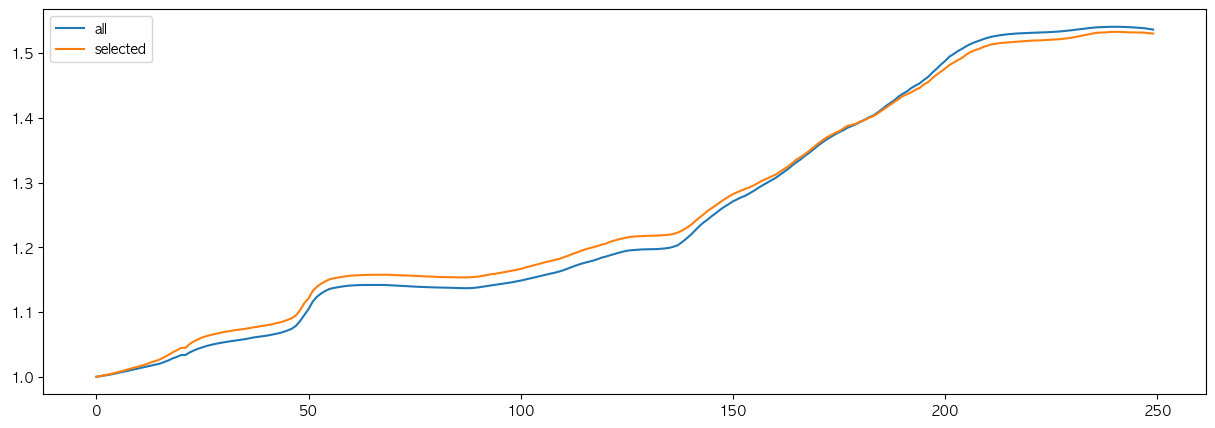

In [234]:
norm_data = normalize(df2)
norm_data.plot(figsize = (15, 5))

In [63]:
interactive_plot(norm_data, 'Time plot based index Price')

### Geo Visualization

In [93]:
import geopandas as gpd
gpd.__version__

'0.11.1'

서울시등의 대한민국 geo 정보의 최신자료는 아래 링크에서 구할 수 있다. 

http://www.gisdeveloper.co.kr/?p=2332

* shape file 이란 ?

> .shp, .shx, .dbf 3개의 파일을 합쳐서 shape file 이라고 한다. shpae file은 GIS에서 사용하는 벡터 형식의 데이터 이다. 
> - .shp : 점, 다각형 등의 지리정보를 담고 있다. 이 때 지리정보의 타입은 혼용되지 않는다. 점과 다각형이 같은 파일에 저장 될 수 없다는 뜻이다. 
> - .shx : 지리정보의 인덱스 정보를 담고 있다. 
> - .dbf : 지리정보의 속성 정보를 담고 있다. 

.shp 파일은 나머지 .dbf, .shx 파일이 없으면 불러올 수 없다. 하나의 위치로 모아주어야 한다. 

> - BAS_MGT_SN : 기초구역 관리번호
> - CTP_KOR_NM : 시도명
> - SIG_CD : 시군구코드
> - SIG_KOR_NM : 시군구명
> - BAS_ID : 기초구역번호 본번
> - BAS_AR :  기초구역 면적(km²)
> - NTFC_DE : 고시일자
> - MVMN_DE : 이동일자
> - MVMN_RESN : 이동사유
> - OPERT_DE : 작업일시

##### 기타 전국, 서울 동 , 서울 구

In [106]:
korea_file = "./EMD_20220324/emd.shp"
korea = gpd.read_file(korea_file, encoding='euckr')
korea.tail()

,EMD_CD,EMD_ENG_NM,EMD_KOR_NM,geometry
5049,50130250,Daejeong-eup,대정읍,"MULTIPOLYGON (((881168.350 1472982.219, 881161..."
5050,50130253,Namwon-eup,남원읍,"MULTIPOLYGON (((910755.915 1486589.634, 910923..."
5051,50130259,Seongsan-eup,성산읍,"MULTIPOLYGON (((943356.999 1498892.763, 943357..."
5052,50130310,Andeok-myeon,안덕면,"MULTIPOLYGON (((888981.846 1471424.888, 888979..."
5053,50130320,Pyoseon-myeon,표선면,"POLYGON ((932601.392 1479746.864, 932586.514 1..."


In [117]:
seoul_file = "./seoul_geo/LSMD_ADM_SECT_UMD_11.shp"
seoul = gpd.read_file(seoul_file, encoding='euckr')
seoul.tail()

,EMD_CD,EMD_NM,SGG_OID,COL_ADM_SE,GID,geometry
461,11680113,율현동,1176,11680,2672,"POLYGON ((964689.142 1941308.304, 964689.914 1..."
462,11680112,자곡동,1175,11680,2673,"POLYGON ((964929.809 1941451.118, 964924.469 1..."
463,11680111,세곡동,1168,11680,2674,"POLYGON ((963659.597 1941082.092, 963691.285 1..."
464,11560114,당산동4가,4650,11560,2725,"POLYGON ((947231.269 1947575.041, 947230.965 1..."
465,11560113,당산동3가,34,11560,2726,"POLYGON ((947224.641 1947574.017, 947214.736 1..."


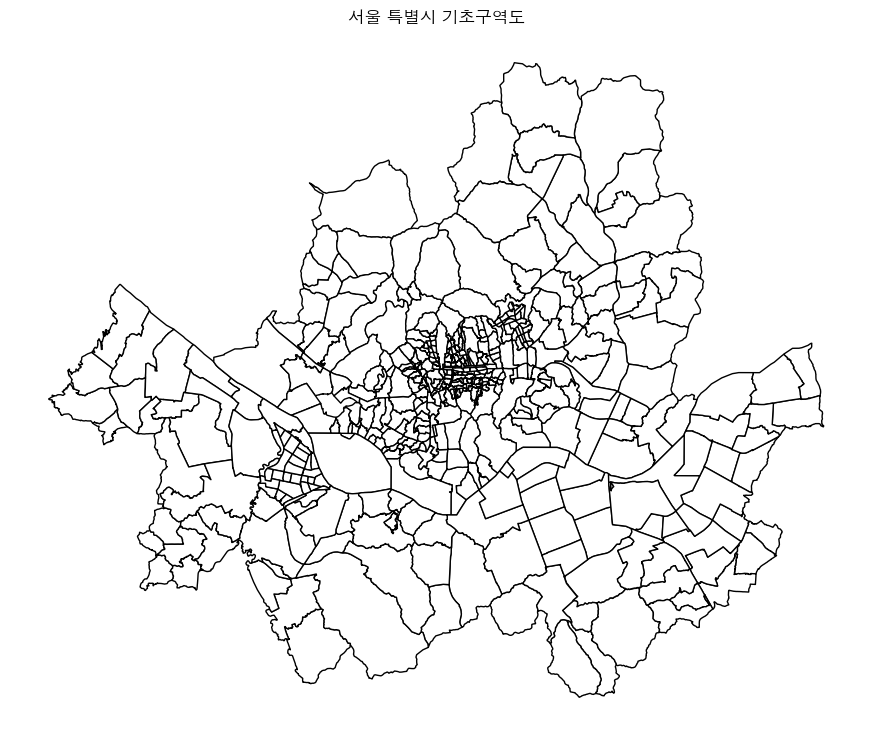

In [108]:
ax = seoul.plot(figsize=(11, 11), color="w", edgecolor="k")
ax.set_title("서울 특별시 기초구역도")
ax.set_axis_off()
plt.show()

##### 서울 - 구

In [193]:
seoul_gu_file = "./SIG_20220324/sig.shp"
seoul_gu = gpd.read_file(seoul_gu_file, encoding='euckr')
seoul_gu = seoul_gu.loc[0:24]
seoul_gu

,SIG_CD,SIG_ENG_NM,SIG_KOR_NM,geometry
0,11110,Jongno-gu,종로구,"POLYGON ((956615.453 1953567.199, 956621.579 1..."
1,11140,Jung-gu,중구,"POLYGON ((957890.386 1952616.746, 957909.908 1..."
2,11170,Yongsan-gu,용산구,"POLYGON ((953115.761 1950834.084, 953114.206 1..."
3,11200,Seongdong-gu,성동구,"POLYGON ((959681.109 1952649.605, 959842.412 1..."
4,11215,Gwangjin-gu,광진구,"POLYGON ((964825.058 1952633.250, 964875.565 1..."
5,11230,Dongdaemun-gu,동대문구,"POLYGON ((962141.919 1956519.461, 962149.853 1..."
6,11260,Jungnang-gu,중랑구,"POLYGON ((965698.531 1957987.355, 965772.290 1..."
7,11290,Seongbuk-gu,성북구,"POLYGON ((956787.318 1953542.506, 956761.258 1..."
8,11305,Gangbuk-gu,강북구,"POLYGON ((956316.789 1965175.345, 956401.551 1..."
9,11320,Dobong-gu,도봉구,"POLYGON ((957223.835 1961199.545, 957195.758 1..."


In [199]:
# GEO data에 QAOA 결과값 추가하기 
seoul_gu = seoul_gu.sort_values('SIG_KOR_NM')
seoul_gu['QAOA_results'] = list(result2.values())
seoul_gu

,SIG_CD,SIG_ENG_NM,SIG_KOR_NM,geometry,QAOA_results
22,11680,Gangnam-gu,강남구,"POLYGON ((959331.597 1948602.068, 959342.021 1...",0.0
24,11740,Gangdong-gu,강동구,"POLYGON ((971595.075 1952405.815, 971596.036 1...",1.0
8,11305,Gangbuk-gu,강북구,"POLYGON ((956316.789 1965175.345, 956401.551 1...",0.0
15,11500,Gangseo-gu,강서구,"POLYGON ((939006.015 1955916.461, 939036.124 1...",0.0
20,11620,Gwanak-gu,관악구,"POLYGON ((949438.997 1944127.713, 949456.647 1...",0.0
4,11215,Gwangjin-gu,광진구,"POLYGON ((964825.058 1952633.250, 964875.565 1...",1.0
16,11530,Guro-gu,구로구,"POLYGON ((945165.294 1946679.190, 945362.702 1...",0.0
17,11545,Geumcheon-gu,금천구,"POLYGON ((944705.924 1943086.537, 944706.472 1...",0.0
10,11350,Nowon-gu,노원구,"POLYGON ((965666.474 1959953.152, 965671.165 1...",0.0
9,11320,Dobong-gu,도봉구,"POLYGON ((957223.835 1961199.545, 957195.758 1...",0.0


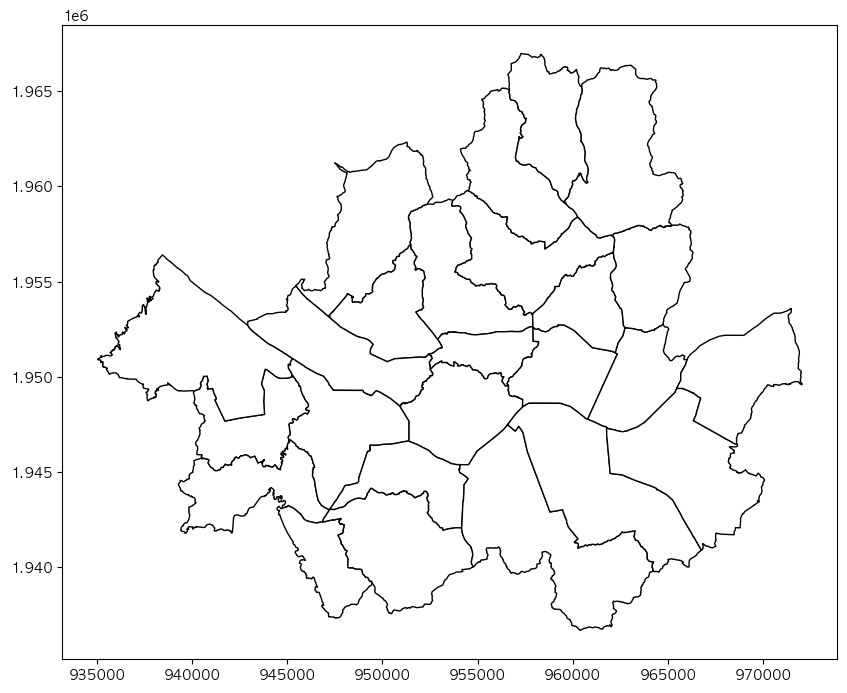

In [148]:
ax = seoul_gu.plot(figsize=(10, 10), color="w", edgecolor="k")
plt.show()

https://towardsdatascience.com/how-to-make-a-gif-map-using-python-geopandas-and-matplotlib-cd8827cefbc8

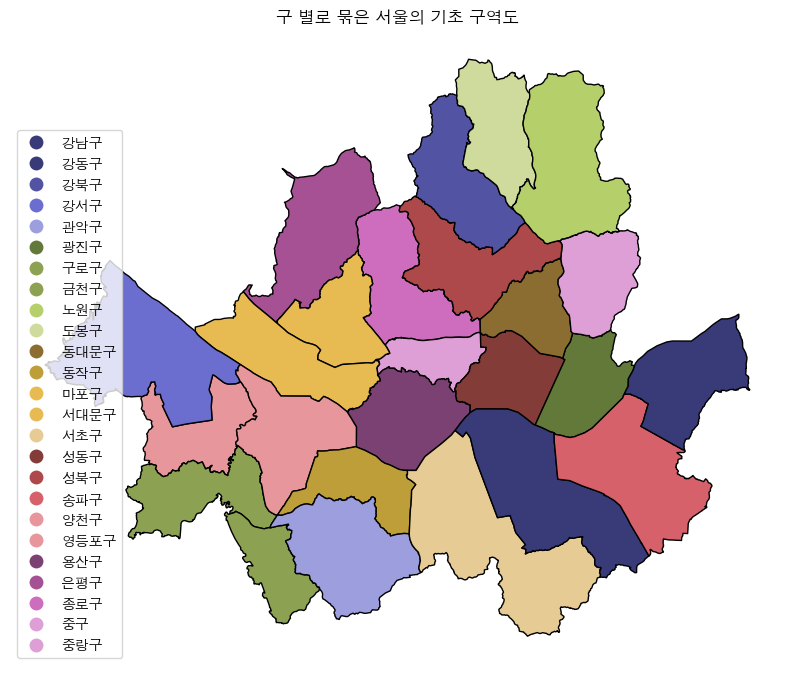

In [157]:
# seoul_gu = seoul_gu.dissolve(by='SIG_CD')
ax = seoul_gu.plot(figsize=(10, 10), column="SIG_KOR_NM", categorical=True,
                cmap="tab20b", edgecolor="k", legend=True, legend_kwds={'loc': 3})
ax.set_title("구 별로 묶은 서울의 기초 구역도")
ax.set_axis_off()
plt.show()

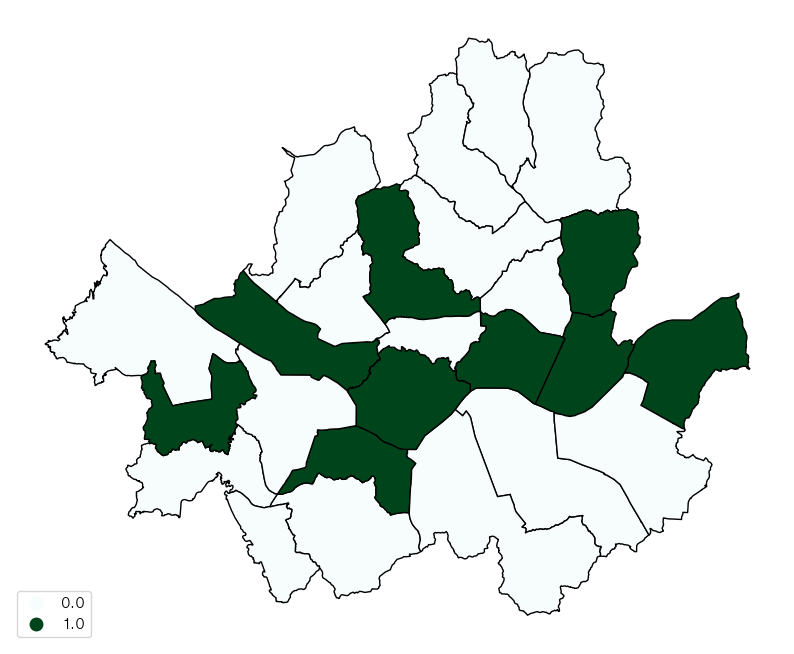

In [205]:
variable = 'QAOA_results'
vmin, vmax = 0 , 1
# fig, ax = plt.subplots(1, figsize = (10,10))
ax = seoul_gu.plot(figsize=(10, 10), column=variable, categorical=True,
                cmap="BuGn", edgecolor="k", legend=True, legend_kwds={'loc': 3})
ax.set_axis_off()
plt.show()

##### shapefile Example

In [164]:
import shapefile as shp
import matplotlib.pyplot as plt
import seaborn as sns

In [183]:
sf = shp.Reader(seoul_gu_file, encoding = 'euckr')
sf.fields

[('DeletionFlag', 'C', 1, 0),
 ['SIG_CD', 'C', 5, 0],
 ['SIG_ENG_NM', 'C', 40, 0],
 ['SIG_KOR_NM', 'C', 40, 0]]

In [177]:
def plot_map_fill_multiples_ids(title, city, sf, 
                                               x_lim = None, 
                                               y_lim = None, 
                                               figsize = (11,9), 
                                               color = 'r'):
  
    plt.figure(figsize = figsize)
    fig, ax = plt.subplots(figsize = figsize)
    fig.suptitle(title, fontsize=16)
    for shape in sf.shapeRecords():
        x = [i[0] for i in shape.shape.points[:]]
        y = [i[1] for i in shape.shape.points[:]]
        ax.plot(x, y, 'k')
            
    for id in city:
        shape_ex = sf.shape(id)
        x_lon = np.zeros((len(shape_ex.points),1))
        y_lat = np.zeros((len(shape_ex.points),1))
        for ip in range(len(shape_ex.points)):
            x_lon[ip] = shape_ex.points[ip][0]
            y_lat[ip] = shape_ex.points[ip][1]
        ax.fill(x_lon,y_lat, color)
             
        x0 = np.mean(x_lon)
        y0 = np.mean(y_lat)
        plt.text(x0, y0, id, fontsize=10)
    
    if (x_lim != None) & (y_lim != None):     
        plt.xlim(x_lim)
        plt.ylim(y_lim)

In [182]:
sf.shape

<bound method Reader.shape of <shapefile.Reader object at 0x30236f490>>

<Figure size 1100x900 with 0 Axes>

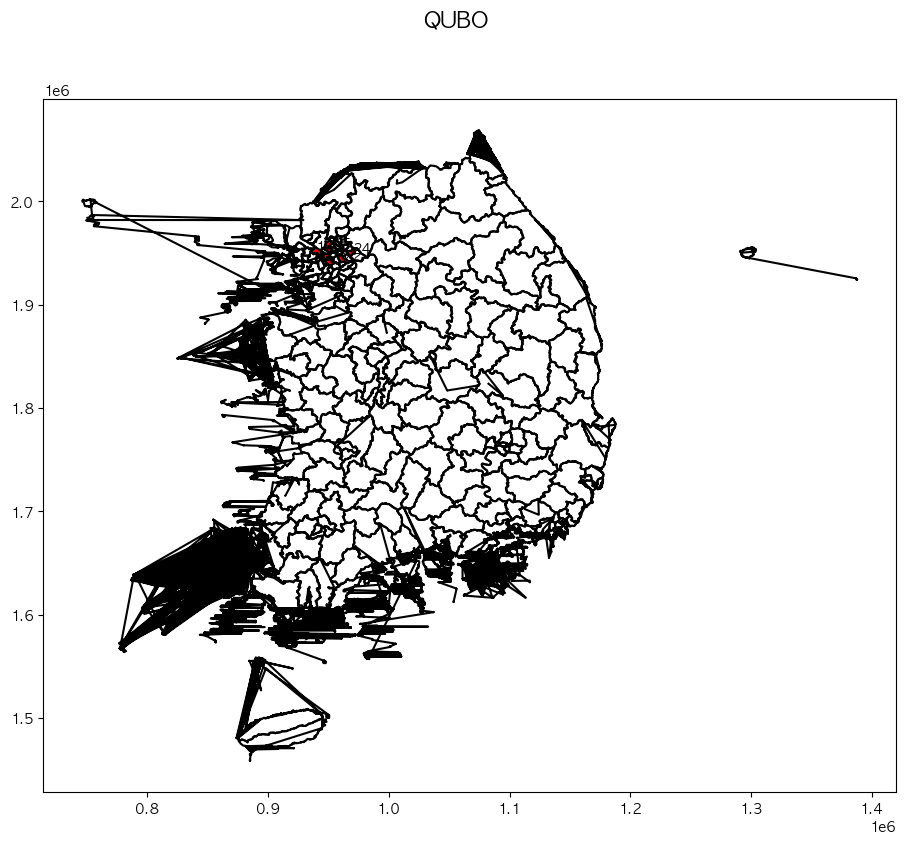

In [178]:
plot_map_fill_multiples_ids('QUBO',selected_gu_idx,sf)

## ETC

In [22]:
# beta 값을 그냥 단순 수익률로 하면 안될까?

In [23]:
# r_2 값 구하는 식
r_squared_list = []
for i in range(p):
    model = LinearRegression()
    X, y = data_x[["x"+str(i)]], data_y
    model.fit(X, y)
    r_squared = model.score(X, y)
    r_squared_list.append(model.score(X, y))

NameError: name 'p' is not defined

In [ ]:
#integer_list = []
#for i in range(10):
#integer_list.append(Integer(str("x")+str("0")+str("0")+str(i), upper_bound=1,lower_bound=0))
#for i in range(10,25) :
#integer_list.append(Integer(str("x")+str("0")+str(i), upper_bound=1,lower_bound=0))
beta_list = list ( beta.values() )
B=beta_list

integer_list = []
for i in range(25):
    integer_list.append(Integer(str(names[i]), upper_bound=1,lower_bound=0))

linear_qubo = B[0]*integer_list[0]*0
for i in range(25): 
    linear_qubo = linear_qubo + B[i]*integer_list[i]

for i in range(25) : 
    Q.iloc[i,i] = 0
quadratic_qubo = Q[0][0]*integer_list[0]*integer_list[0]*0
for j in range(25):
    for i in range(25):
        quadratic_qubo= quadratic_qubo+Q[i][j]*integer_list[i]*integer_list[j]
        
Qubo = -linear_qubo + 10000*quadratic_qubo

In [ ]:
# Qubo 와 result - 기존 Q 에 가중치를 크게 둠 , 그냥 한번 더, 결과에는 변화 x
# beta 값이 용산이 크고.. 반대가 되어야하는거 아닌가?

cqm= ConstrainedQuadraticModel()
cqm.set_objective(Qubo)
sampleset = sampler.sample_cqm(cqm)

result3 = sampleset.first[0]
result_list3=list(zip(result.keys(), result.values()))

In [ ]:
result3 

{'강남구': 0.0,
 '강동구': 1.0,
 '강북구': 0.0,
 '강서구': 0.0,
 '관악구': 0.0,
 '광진구': 1.0,
 '구로구': 0.0,
 '금천구': 0.0,
 '노원구': 0.0,
 '도봉구': 0.0,
 '동대문구': 0.0,
 '동작구': 1.0,
 '마포구': 0.0,
 '서대문구': 0.0,
 '서초구': 0.0,
 '성동구': 0.0,
 '성북구': 0.0,
 '송파구': 0.0,
 '양천구': 0.0,
 '영등포구': 0.0,
 '용산구': 1.0,
 '은평구': 0.0,
 '종로구': 1.0,
 '중구': 0.0,
 '중랑구': 1.0}

In [ ]:
B[25]

IndexError: list index out of range

In [ ]:
New_B = []
for i in range ( 24) :
    New_B[i] = 1- B[i]

IndexError: list assignment index out of range